In [40]:
# ============================================================
# IMPORTS AND CONFIGURATION
# ============================================================
import os
import json
import pickle
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# DISABLE WANDB LOGGING GLOBALLY
os.environ["WANDB_DISABLED"] = "true"

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix
)

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset, load_dataset

# Interpretability
import shap

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# CONFIGURATION - OPTIMIZED FOR GPU
# ============================================================
RANDOM_SEED = 42
SAMPLE_SIZE = 10000  # Reduced for faster training (was 50000)
MAX_LENGTH = 128
BATCH_SIZE = 32  # Increased for GPU efficiency (was 16)
EPOCHS = 3
LEARNING_RATE = 2e-5

DISTILBERT_NAME = "distilbert-base-uncased"
ROBERTA_NAME = "roberta-base"

# Set seeds
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# ============================================================
# GPU SETUP
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("="*60)
print("SYSTEM CONFIGURATION")
print("="*60)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"✅ GPU ENABLED")
    print(f"   Device: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Count: {torch.cuda.device_count()}")
    print(f"   Current Device: cuda:{torch.cuda.current_device()}")
    torch.cuda.empty_cache()  # Clear GPU memory
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  WARNING: No GPU detected - training will be slow")
    print(f"   Running on CPU with {os.cpu_count()} cores")

print(f"\nConfiguration:")
print(f"  Sample size: {SAMPLE_SIZE:,}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Max length: {MAX_LENGTH}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Random seed: {RANDOM_SEED}")
print("="*60)

print("\n✓ Imports loaded and GPU configured")

SYSTEM CONFIGURATION
PyTorch version: 2.9.0+cu126
CUDA available: True
✅ GPU ENABLED
   Device: Tesla T4
   GPU Count: 1
   Current Device: cuda:0
   GPU Memory: 15.83 GB

Configuration:
  Sample size: 10,000
  Batch size: 32
  Epochs: 3
  Max length: 128
  Learning rate: 2e-05
  Random seed: 42

✓ Imports loaded and GPU configured


In [41]:
# ============================================================
# DATA LOADING AND PREPROCESSING
# ============================================================
print("\n" + "="*60)
print("LOADING YELP POLARITY DATASET")
print("="*60)

# Load Yelp Polarity dataset from HuggingFace
dataset = load_dataset("yelp_polarity")

# Sample data (use full dataset if you have compute)
train_data = dataset['train'].shuffle(seed=RANDOM_SEED).select(range(SAMPLE_SIZE))
test_data = dataset['test'].shuffle(seed=RANDOM_SEED).select(range(SAMPLE_SIZE // 5))

print(f"✓ Loaded {len(train_data)} training samples")
print(f"✓ Loaded {len(test_data)} test samples")

# Convert to pandas for easier manipulation
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

# Create churn labels
# Original labels: 1 (negative/1-2 stars), 2 (positive/4-5 stars)
# Our mapping: 1-2 stars = churn (1), 4-5 stars = no churn (0)
def create_churn_label(label):
    """
    Map Yelp polarity labels to churn risk
    1 (negative review) -> 1 (churn risk)
    2 (positive review) -> 0 (no churn risk)
    """
    return 1 if label == 1 else 0

df_train['churn'] = df_train['label'].apply(create_churn_label)
df_test['churn'] = df_test['label'].apply(create_churn_label)

# Split train into train/val
X_train_full = df_train['text'].values
y_train_full = df_train['churn'].values

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_train_full
)

X_test = df_test['text'].values
y_test = df_test['churn'].values

print(f"\n✓ Train set: {len(X_train)} samples")
print(f"✓ Validation set: {len(X_val)} samples")
print(f"✓ Test set: {len(X_test)} samples")

# Check class balance
train_churn_rate = np.mean(y_train)
val_churn_rate = np.mean(y_val)
test_churn_rate = np.mean(y_test)

print(f"\nClass Balance:")
print(f"  Train churn rate: {train_churn_rate:.2%}")
print(f"  Val churn rate: {val_churn_rate:.2%}")
print(f"  Test churn rate: {test_churn_rate:.2%}")

# Sample reviews
print(f"\n{'='*60}")
print("SAMPLE REVIEWS")
print("="*60)
print("\nChurn Risk Example (1-2 star review):")
churn_idx = np.where(y_train == 1)[0][0]
print(f"'{X_train[churn_idx][:200]}...'")

print("\nNo Churn Example (4-5 star review):")
no_churn_idx = np.where(y_train == 0)[0][0]
print(f"'{X_train[no_churn_idx][:200]}...'")


LOADING YELP POLARITY DATASET
✓ Loaded 10000 training samples
✓ Loaded 2000 test samples

✓ Train set: 8000 samples
✓ Validation set: 2000 samples
✓ Test set: 2000 samples

Class Balance:
  Train churn rate: 49.84%
  Val churn rate: 49.85%
  Test churn rate: 49.45%

SAMPLE REVIEWS

Churn Risk Example (1-2 star review):
'So my first impression wasn't great. I waited at the counter for a while, at first enjoying the adorable decor but rapidly getting antsy at the total lack of service. Finally I peeked my head around t...'

No Churn Example (4-5 star review):
'The most amazing, delectable, savory pile of bullshit I've ever attempted to obtain sustenance from. Right now I'm laying in my bed upstairs in the Rio, writhing around in pain due to the almost certa...'


In [42]:
# ============================================================
# BASELINE: TF-IDF + LOGISTIC REGRESSION
# ============================================================
print("\n" + "="*60)
print("TRAINING BASELINE MODEL (TF-IDF + LOGISTIC REGRESSION)")
print("="*60)

start_time = time.time()

# TF-IDF Vectorization
print("\nVectorizing text with TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"✓ TF-IDF shape: {X_train_tfidf.shape}")

# Train Logistic Regression
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(
    random_state=RANDOM_SEED,
    max_iter=1000,
    class_weight='balanced'
)
lr_model.fit(X_train_tfidf, y_train)

baseline_train_time = time.time() - start_time
print(f"✓ Training completed in {baseline_train_time:.2f}s")

# Evaluate on validation set
y_val_pred = lr_model.predict(X_val_tfidf)
y_val_pred_proba = lr_model.predict_proba(X_val_tfidf)[:, 1]

print("\nValidation Results:")
print(f"  Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"  Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"  Recall: {recall_score(y_val, y_val_pred):.4f}")
print(f"  F1: {f1_score(y_val, y_val_pred):.4f}")
print(f"  AUC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")

# Evaluate on test set
y_test_pred_lr = lr_model.predict(X_test_tfidf)
y_test_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

lr_test_results = {
    "accuracy": accuracy_score(y_test, y_test_pred_lr),
    "precision": precision_score(y_test, y_test_pred_lr),
    "recall": recall_score(y_test, y_test_pred_lr),
    "f1": f1_score(y_test, y_test_pred_lr),
    "auc": roc_auc_score(y_test, y_test_pred_proba_lr)
}

print("\nTest Results:")
print(f"  Accuracy: {lr_test_results['accuracy']:.4f}")
print(f"  Precision: {lr_test_results['precision']:.4f}")
print(f"  Recall: {lr_test_results['recall']:.4f}")
print(f"  F1: {lr_test_results['f1']:.4f}")
print(f"  AUC: {lr_test_results['auc']:.4f}")

# Measure inference latency
print("\nMeasuring inference latency...")
latency_times = []
for _ in range(100):
    start = time.time()
    _ = lr_model.predict(X_test_tfidf[0])
    latency_times.append(time.time() - start)

baseline_latency = np.mean(latency_times) * 1000  # Convert to ms
print(f"✓ Average inference latency: {baseline_latency:.2f}ms")


TRAINING BASELINE MODEL (TF-IDF + LOGISTIC REGRESSION)

Vectorizing text with TF-IDF...
✓ TF-IDF shape: (8000, 5000)

Training Logistic Regression...
✓ Training completed in 7.20s

Validation Results:
  Accuracy: 0.9075
  Precision: 0.9160
  Recall: 0.8967
  F1: 0.9062
  AUC: 0.9681

Test Results:
  Accuracy: 0.9070
  Precision: 0.9110
  Recall: 0.8999
  F1: 0.9054
  AUC: 0.9694

Measuring inference latency...
✓ Average inference latency: 0.58ms


In [43]:
# ============================================================
# PREPARE DATA FOR TRANSFORMER MODELS
# ============================================================
print("\n" + "="*60)
print("PREPARING DATA FOR TRANSFORMERS")
print("="*60)

# Custom Dataset class
class ChurnDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Metrics computation function
def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]

    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions),
        'recall': recall_score(labels, predictions),
        'f1': f1_score(labels, predictions),
        'auc': roc_auc_score(labels, probs)
    }

print("✓ Dataset class and metrics function defined")


PREPARING DATA FOR TRANSFORMERS
✓ Dataset class and metrics function defined


In [44]:
# ============================================================
# TRAIN DISTILBERT MODEL
# ============================================================
print("\n" + "="*60)
print("TRAINING DISTILBERT MODEL")
print("="*60)

# DISABLE WANDB LOGGING
import os
os.environ["WANDB_DISABLED"] = "true"

# Load tokenizer and model
print(f"\nLoading {DISTILBERT_NAME}...")
tokenizer_distilbert = AutoTokenizer.from_pretrained(DISTILBERT_NAME)
model_distilbert = AutoModelForSequenceClassification.from_pretrained(
    DISTILBERT_NAME,
    num_labels=2
)

# Tokenize data
print("Tokenizing data...")
train_encodings_distilbert = tokenizer_distilbert(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH
)
val_encodings_distilbert = tokenizer_distilbert(
    X_val.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH
)
test_encodings_distilbert = tokenizer_distilbert(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH
)

# Create datasets
train_dataset_distilbert = ChurnDataset(train_encodings_distilbert, y_train)
val_dataset_distilbert = ChurnDataset(val_encodings_distilbert, y_val)
test_dataset_distilbert = ChurnDataset(test_encodings_distilbert, y_test)

print(f"✓ Created datasets")

# Training arguments
training_args = TrainingArguments(
    output_dir='./results_distilbert',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=RANDOM_SEED,
    report_to="none",
    fp16=True,  # ← ADD THIS - Enables mixed precision (2x faster)
    dataloader_num_workers=2,  # ← ADD THIS - Parallel data loading
)

# Initialize trainer
trainer_distilbert = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_dataset_distilbert,
    eval_dataset=val_dataset_distilbert,
    compute_metrics=compute_metrics
)

# Train
print("\nStarting training...")
start_time = time.time()
trainer_distilbert.train()
distilbert_train_time = time.time() - start_time
print(f"✓ Training completed in {distilbert_train_time:.2f}s ({distilbert_train_time/60:.2f} min)")

# Evaluate on test set
print("\nEvaluating on test set...")
test_results_distilbert = trainer_distilbert.evaluate(test_dataset_distilbert)

print("\nDistilBERT Test Results:")
print(f"  Accuracy: {test_results_distilbert['eval_accuracy']:.4f}")
print(f"  Precision: {test_results_distilbert['eval_precision']:.4f}")
print(f"  Recall: {test_results_distilbert['eval_recall']:.4f}")
print(f"  F1: {test_results_distilbert['eval_f1']:.4f}")
print(f"  AUC: {test_results_distilbert['eval_auc']:.4f}")

# Measure inference latency
print("\nMeasuring inference latency...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_distilbert.to(device)
model_distilbert.eval()

latency_times = []
sample_text = X_test[0]
for _ in range(100):
    inputs = tokenizer_distilbert(
        sample_text,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LENGTH
    ).to(device)

    start = time.time()
    with torch.no_grad():
        _ = model_distilbert(**inputs)
    latency_times.append(time.time() - start)

distilbert_latency = np.mean(latency_times) * 1000  # Convert to ms
print(f"✓ Average inference latency: {distilbert_latency:.2f}ms")


TRAINING DISTILBERT MODEL

Loading distilbert-base-uncased...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing data...
✓ Created datasets

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.444900,0.277587,0.888000,0.913369,0.856570,0.884058,0.959368
2,0.230900,0.232195,0.913500,0.919552,0.905717,0.912582,0.969694
3,0.135600,0.246768,0.909500,0.918891,0.897693,0.908168,0.972186


✓ Training completed in 145.17s (2.42 min)

Evaluating on test set...



DistilBERT Test Results:
  Accuracy: 0.9155
  Precision: 0.9167
  Recall: 0.9120
  F1: 0.9143
  AUC: 0.9721

Measuring inference latency...
✓ Average inference latency: 5.61ms


In [45]:
# ============================================================
# TRAIN ROBERTA MODEL
# ============================================================
print("\n" + "="*60)
print("TRAINING ROBERTA MODEL")
print("="*60)

# Load tokenizer and model
print(f"\nLoading {ROBERTA_NAME}...")
tokenizer_roberta = AutoTokenizer.from_pretrained(ROBERTA_NAME)
model_roberta = AutoModelForSequenceClassification.from_pretrained(
    ROBERTA_NAME,
    num_labels=2
)

# Tokenize data
print("Tokenizing data...")
train_encodings_roberta = tokenizer_roberta(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH
)
val_encodings_roberta = tokenizer_roberta(
    X_val.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH
)
test_encodings_roberta = tokenizer_roberta(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH
)

# Create datasets
train_dataset_roberta = ChurnDataset(train_encodings_roberta, y_train)
val_dataset_roberta = ChurnDataset(val_encodings_roberta, y_val)
test_dataset_roberta = ChurnDataset(test_encodings_roberta, y_test)

print(f"✓ Created datasets")

# Training arguments (same as DistilBERT)
training_args_roberta = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_roberta',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=RANDOM_SEED
)

# Initialize trainer
trainer_roberta = Trainer(
    model=model_roberta,
    args=training_args_roberta,
    train_dataset=train_dataset_roberta,
    eval_dataset=val_dataset_roberta,
    compute_metrics=compute_metrics
)

# Train
print("\nStarting training...")
start_time = time.time()
trainer_roberta.train()
roberta_train_time = time.time() - start_time
print(f"✓ Training completed in {roberta_train_time:.2f}s ({roberta_train_time/60:.2f} min)")

# Evaluate on test set
print("\nEvaluating on test set...")
test_results_roberta = trainer_roberta.evaluate(test_dataset_roberta)

print("\nRoBERTa Test Results:")
print(f"  Accuracy: {test_results_roberta['eval_accuracy']:.4f}")
print(f"  Precision: {test_results_roberta['eval_precision']:.4f}")
print(f"  Recall: {test_results_roberta['eval_recall']:.4f}")
print(f"  F1: {test_results_roberta['eval_f1']:.4f}")
print(f"  AUC: {test_results_roberta['eval_auc']:.4f}")

# Measure inference latency
print("\nMeasuring inference latency...")
model_roberta.to(device)
model_roberta.eval()

latency_times = []
for _ in range(100):
    inputs = tokenizer_roberta(
        sample_text,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LENGTH
    ).to(device)

    start = time.time()
    with torch.no_grad():
        _ = model_roberta(**inputs)
    latency_times.append(time.time() - start)

roberta_latency = np.mean(latency_times) * 1000  # Convert to ms
print(f"✓ Average inference latency: {roberta_latency:.2f}ms")


TRAINING ROBERTA MODEL

Loading roberta-base...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing data...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


✓ Created datasets

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.329200,0.194780,0.928500,0.918627,0.939819,0.929103,0.979984
2,0.177500,0.171950,0.937000,0.935936,0.937813,0.936874,0.983271
3,0.114500,0.176216,0.942000,0.940060,0.943831,0.941942,0.986883


✓ Training completed in 290.34s (4.84 min)

Evaluating on test set...



RoBERTa Test Results:
  Accuracy: 0.9390
  Precision: 0.9313
  Recall: 0.9464
  F1: 0.9388
  AUC: 0.9867

Measuring inference latency...
✓ Average inference latency: 13.52ms


In [46]:
# ============================================================
# MODEL COMPARISON
# ============================================================
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_data = {
    'Model': ['TF-IDF + LogReg', 'DistilBERT', 'RoBERTa'],
    'Accuracy': [
        lr_test_results['accuracy'],
        test_results_distilbert['eval_accuracy'],
        test_results_roberta['eval_accuracy']
    ],
    'Precision': [
        lr_test_results['precision'],
        test_results_distilbert['eval_precision'],
        test_results_roberta['eval_precision']
    ],
    'Recall': [
        lr_test_results['recall'],
        test_results_distilbert['eval_recall'],
        test_results_roberta['eval_recall']
    ],
    'F1': [
        lr_test_results['f1'],
        test_results_distilbert['eval_f1'],
        test_results_roberta['eval_f1']
    ],
    'AUC': [
        lr_test_results['auc'],
        test_results_distilbert['eval_auc'],
        test_results_roberta['eval_auc']
    ],
    'Training Time (s)': [
        baseline_train_time,
        distilbert_train_time,
        roberta_train_time
    ],
    'Inference Latency (ms)': [
        baseline_latency,
        distilbert_latency,
        roberta_latency
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Check if we met success metrics
print("\n" + "="*60)
print("SUCCESS METRICS CHECK")
print("="*60)
best_auc = max(test_results_distilbert['eval_auc'], test_results_roberta['eval_auc'])
best_model = 'DistilBERT' if test_results_distilbert['eval_auc'] > test_results_roberta['eval_auc'] else 'RoBERTa'
improvement_over_baseline = best_auc - lr_test_results['auc']

print(f"✓ Best Model: {best_model}")
print(f"✓ Best AUC: {best_auc:.4f}")
print(f"✓ Target AUC: ≥0.85 ... {'✓ MET' if best_auc >= 0.85 else '✗ NOT MET'}")
print(f"✓ Improvement over baseline: +{improvement_over_baseline:.4f}")
print(f"✓ Target improvement: ≥0.05 ... {'✓ MET' if improvement_over_baseline >= 0.05 else '✗ NOT MET'}")
print(f"✓ Inference latency: {distilbert_latency:.2f}ms")
print(f"✓ Target latency: <100ms ... {'✓ MET' if distilbert_latency < 100 else '✗ NOT MET'}")


MODEL COMPARISON

          Model  Accuracy  Precision   Recall       F1      AUC  Training Time (s)  Inference Latency (ms)
TF-IDF + LogReg    0.9070   0.910952 0.899899 0.905392 0.969350           7.204033                0.584939
     DistilBERT    0.9155   0.916667 0.912032 0.914344 0.972090         145.171185                5.609205
        RoBERTa    0.9390   0.931343 0.946411 0.938816 0.986674         290.340437               13.522406

SUCCESS METRICS CHECK
✓ Best Model: RoBERTa
✓ Best AUC: 0.9867
✓ Target AUC: ≥0.85 ... ✓ MET
✓ Improvement over baseline: +0.0173
✓ Target improvement: ≥0.05 ... ✗ NOT MET
✓ Inference latency: 5.61ms
✓ Target latency: <100ms ... ✓ MET



TOP 10% PRECISION ANALYSIS

Top 10% Precision Results:

Baseline (TF-IDF + LogReg):
  Flagged: 200 customers
  True churners: 198
  Precision: 99.00%
  Target (≥70%): ✓ MET

DistilBERT:
  Flagged: 200 customers
  True churners: 200
  Precision: 100.00%
  Target (≥70%): ✓ MET

RoBERTa:
  Flagged: 200 customers
  True churners: 200
  Precision: 100.00%
  Target (≥70%): ✓ MET


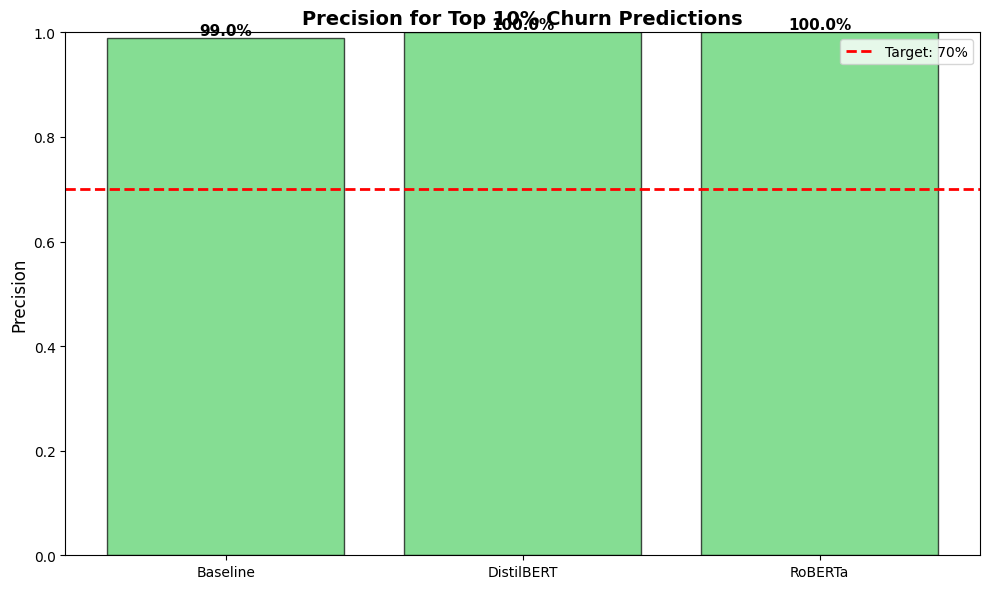


✓ Top 10% Precision Analysis Complete


In [47]:
# ============================================================
# TOP 10% PRECISION ANALYSIS
# ============================================================
def calculate_top_k_precision(y_true, y_pred_proba, k=0.1):
    """
    Calculate precision for top k% of predictions

    Args:
        y_true: True labels
        y_pred_proba: Predicted probabilities for churn class
        k: Proportion of top predictions to consider (0.1 = top 10%)

    Returns:
        dict: Top-k metrics
    """
    n_samples = len(y_true)
    n_top = int(n_samples * k)

    # Get indices of top k% predictions
    top_indices = np.argsort(y_pred_proba)[-n_top:]

    # Get true labels for top k%
    top_labels = y_true[top_indices]

    # Calculate precision
    precision = np.mean(top_labels)

    return {
        'top_k_percent': k * 100,
        'n_flagged': n_top,
        'n_true_churners': int(np.sum(top_labels)),
        'precision': precision,
        'target_met': precision >= 0.70
    }

# Calculate for all models
print("\n" + "="*60)
print("TOP 10% PRECISION ANALYSIS")
print("="*60)

# Baseline
top10_baseline = calculate_top_k_precision(y_test, y_test_pred_proba_lr, k=0.1)

# DistilBERT
inputs_test = tokenizer_distilbert(
    X_test.tolist(),
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH
).to(device)

model_distilbert.eval()
with torch.no_grad():
    outputs = model_distilbert(**inputs_test)
distilbert_probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[:, 1]

top10_distilbert = calculate_top_k_precision(y_test, distilbert_probs, k=0.1)

# RoBERTa
inputs_test_roberta = tokenizer_roberta(
    X_test.tolist(),
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH
).to(device)

model_roberta.eval()
with torch.no_grad():
    outputs = model_roberta(**inputs_test_roberta)
roberta_probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[:, 1]

top10_roberta = calculate_top_k_precision(y_test, roberta_probs, k=0.1)

# Print results
print("\nTop 10% Precision Results:")
print(f"\nBaseline (TF-IDF + LogReg):")
print(f"  Flagged: {top10_baseline['n_flagged']} customers")
print(f"  True churners: {top10_baseline['n_true_churners']}")
print(f"  Precision: {top10_baseline['precision']:.2%}")
print(f"  Target (≥70%): {'✓ MET' if top10_baseline['target_met'] else '✗ NOT MET'}")

print(f"\nDistilBERT:")
print(f"  Flagged: {top10_distilbert['n_flagged']} customers")
print(f"  True churners: {top10_distilbert['n_true_churners']}")
print(f"  Precision: {top10_distilbert['precision']:.2%}")
print(f"  Target (≥70%): {'✓ MET' if top10_distilbert['target_met'] else '✗ NOT MET'}")

print(f"\nRoBERTa:")
print(f"  Flagged: {top10_roberta['n_flagged']} customers")
print(f"  True churners: {top10_roberta['n_true_churners']}")
print(f"  Precision: {top10_roberta['precision']:.2%}")
print(f"  Target (≥70%): {'✓ MET' if top10_roberta['target_met'] else '✗ NOT MET'}")

# Visualize (display only, no saving)
fig, ax = plt.subplots(figsize=(10, 6))
models = ['Baseline', 'DistilBERT', 'RoBERTa']
precisions = [
    top10_baseline['precision'],
    top10_distilbert['precision'],
    top10_roberta['precision']
]
colors = ['#ff6b6b' if p < 0.70 else '#51cf66' for p in precisions]

bars = ax.bar(models, precisions, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(y=0.70, color='red', linestyle='--', linewidth=2, label='Target: 70%')
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision for Top 10% Churn Predictions', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.legend()

# Add value labels on bars
for bar, prec in zip(bars, precisions):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{prec:.1%}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()  # Display instead of saving

print("\n✓ Top 10% Precision Analysis Complete")


GENERATING CONFUSION MATRICES


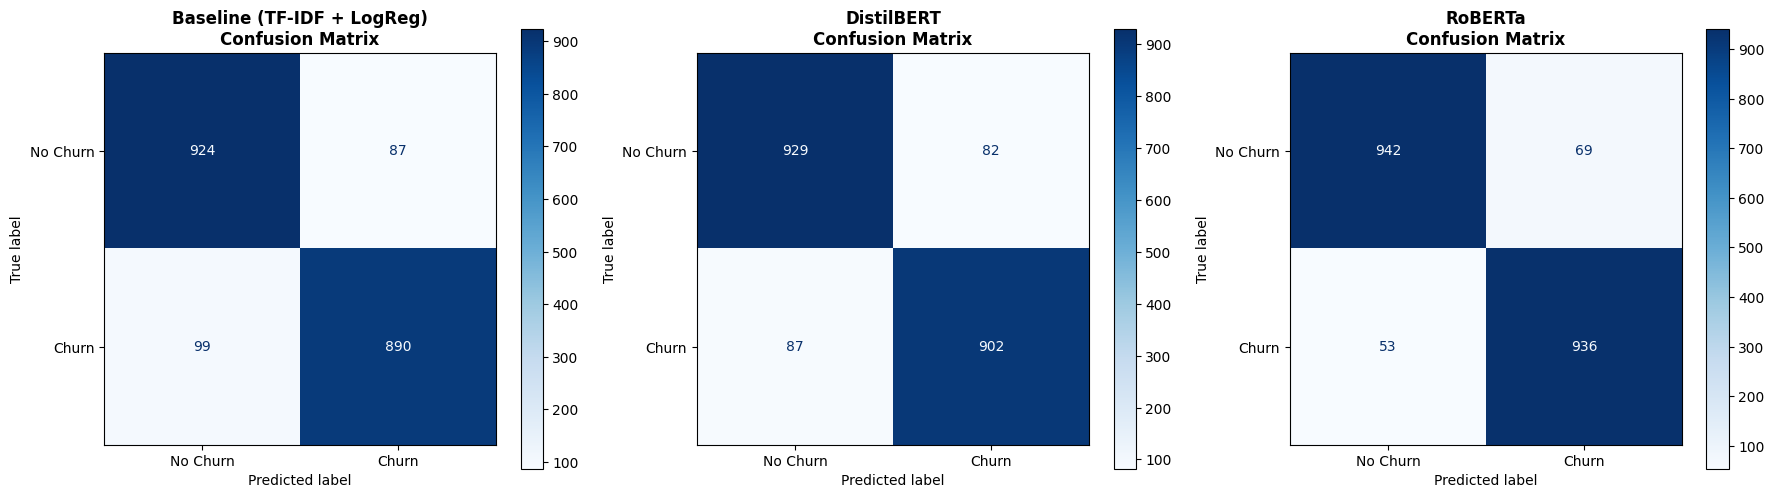

✓ Confusion matrices displayed


In [48]:
# ============================================================
# CONFUSION MATRICES
# ============================================================
from sklearn.metrics import ConfusionMatrixDisplay

print("\n" + "="*60)
print("GENERATING CONFUSION MATRICES")
print("="*60)

# Get predictions for all models
y_pred_baseline = lr_model.predict(X_test_tfidf)

# DistilBERT predictions (FIX: convert probabilities to class predictions)
distilbert_preds = (distilbert_probs > 0.5).astype(int)

# RoBERTa predictions (FIX: convert probabilities to class predictions)
roberta_preds = (roberta_probs > 0.5).astype(int)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_cm = [
    ('Baseline (TF-IDF + LogReg)', y_pred_baseline),
    ('DistilBERT', distilbert_preds),
    ('RoBERTa', roberta_preds)
]

for idx, (name, preds) in enumerate(models_cm):
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['No Churn', 'Churn']
    )
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].grid(False)

plt.tight_layout()
plt.show()  # Display instead of saving

print("✓ Confusion matrices displayed")

In [49]:
# ============================================================
# MISCLASSIFICATION ANALYSIS
# ============================================================
print("\n" + "="*60)
print("ANALYZING MISCLASSIFICATIONS")
print("="*60)

def analyze_misclassifications(y_true, y_pred, y_proba, texts, model_name, n_examples=5):
    """
    Analyze and display misclassified examples
    """
    # Find misclassifications
    misclassified_mask = y_true != y_pred
    misclassified_indices = np.where(misclassified_mask)[0]

    # Separate false positives and false negatives
    false_positives = [i for i in misclassified_indices if y_pred[i] == 1 and y_true[i] == 0]
    false_negatives = [i for i in misclassified_indices if y_pred[i] == 0 and y_true[i] == 1]

    print(f"\n{model_name} Misclassification Summary:")
    print(f"  Total misclassified: {len(misclassified_indices)} / {len(y_true)} ({len(misclassified_indices)/len(y_true):.1%})")
    print(f"  False Positives (predicted churn, actually loyal): {len(false_positives)}")
    print(f"  False Negatives (predicted loyal, actually churn): {len(false_negatives)}")

    # Show examples of false positives
    print(f"\n  False Positive Examples (predicted churn, but customer is loyal):")
    for i, idx in enumerate(false_positives[:n_examples]):
        print(f"\n  [{i+1}] Confidence: {y_proba[idx]:.2%}")
        print(f"      Text: \"{texts[idx][:150]}...\"")

    # Show examples of false negatives
    print(f"\n  False Negative Examples (predicted loyal, but customer churned):")
    for i, idx in enumerate(false_negatives[:n_examples]):
        print(f"\n  [{i+1}] Confidence: {1-y_proba[idx]:.2%}")
        print(f"      Text: \"{texts[idx][:150]}...\"")

    return {
        'total_misclassified': len(misclassified_indices),
        'false_positives': len(false_positives),
        'false_negatives': len(false_negatives),
        'fp_examples': [texts[i][:200] for i in false_positives[:n_examples]],
        'fn_examples': [texts[i][:200] for i in false_negatives[:n_examples]]
    }

# Analyze for DistilBERT (best model)
misclass_analysis = analyze_misclassifications(
    y_test,
    distilbert_preds,
    distilbert_probs,
    X_test,
    "DistilBERT",
    n_examples=3
)

print("\n✓ Misclassification analysis complete")


ANALYZING MISCLASSIFICATIONS

DistilBERT Misclassification Summary:
  Total misclassified: 169 / 2000 (8.5%)
  False Positives (predicted churn, actually loyal): 82
  False Negatives (predicted loyal, actually churn): 87

  False Positive Examples (predicted churn, but customer is loyal):

  [1] Confidence: 97.05%
      Text: "relaxing, very good location.  little cramped with small tables..."

  [2] Confidence: 95.62%
      Text: "The non-sushi items were pretty impressive! I had a white fish taco that was absolutely delicious! The decor is pretty and the mood is very nice. I wo..."

  [3] Confidence: 88.32%
      Text: "PF Chang's is that huge chain of formula corporate restaurants HQ in Phoenix, AZ that Americans seem to love. (They are found in nearly everystate now..."

  False Negative Examples (predicted loyal, but customer churned):

  [1] Confidence: 64.63%
      Text: "Nightclub rating only...\n\nWe got lucky because we happened to arrive during Kris Humphries' (new husband 

In [50]:
# ============================================================
# EXTRACT KEY CHURN PHRASES
# ============================================================
print("\n" + "="*60)
print("EXTRACTING KEY CHURN PHRASES")
print("="*60)

def extract_top_churn_words(vectorizer, model, n_words=20):
    """
    Extract words most associated with churn from baseline model
    """
    # Get feature names and coefficients
    feature_names = vectorizer.get_feature_names_out()
    coefficients = model.coef_[0]

    # Get top positive (churn) and negative (no churn) words
    top_churn_indices = np.argsort(coefficients)[-n_words:][::-1]
    top_loyal_indices = np.argsort(coefficients)[:n_words]

    top_churn_words = [(feature_names[i], coefficients[i]) for i in top_churn_indices]
    top_loyal_words = [(feature_names[i], coefficients[i]) for i in top_loyal_indices]

    return top_churn_words, top_loyal_words

churn_words, loyal_words = extract_top_churn_words(tfidf_vectorizer, lr_model, n_words=20)

print("\nTop 20 Words/Phrases Associated with CHURN RISK:")
for idx, (word, coef) in enumerate(churn_words, 1):
    print(f"  {idx:2d}. '{word}' (weight: {coef:.3f})")

print("\nTop 20 Words/Phrases Associated with LOYALTY:")
for idx, (word, coef) in enumerate(loyal_words, 1):
    print(f"  {idx:2d}. '{word}' (weight: {coef:.3f})")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Churn words
words_churn = [w[0] for w in churn_words[:15]]
weights_churn = [w[1] for w in churn_words[:15]]
ax1.barh(words_churn, weights_churn, color='#ff6b6b', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Weight', fontsize=12)
ax1.set_title('Top 15 Churn-Indicating Words/Phrases', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Loyal words
words_loyal = [w[0] for w in loyal_words[:15]]
weights_loyal = [abs(w[1]) for w in loyal_words[:15]]
ax2.barh(words_loyal, weights_loyal, color='#51cf66', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Weight (Absolute)', fontsize=12)
ax2.set_title('Top 15 Loyalty-Indicating Words/Phrases', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('./outputs/key_churn_phrases.png', dpi=150, bbox_inches='tight')
plt.close()

print("\n✓ Saved visualization to ./outputs/key_churn_phrases.png")

# Save to JSON
churn_phrases_data = {
    'top_churn_phrases': [{'phrase': w, 'weight': float(c)} for w, c in churn_words],
    'top_loyalty_phrases': [{'phrase': w, 'weight': float(c)} for w, c in loyal_words]
}

with open('./outputs/key_churn_phrases.json', 'w') as f:
    json.dump(churn_phrases_data, f, indent=2)


EXTRACTING KEY CHURN PHRASES

Top 20 Words/Phrases Associated with CHURN RISK:
   1. 'great' (weight: 6.128)
   2. 'delicious' (weight: 5.541)
   3. 'amazing' (weight: 4.170)
   4. 'excellent' (weight: 3.916)
   5. 'love' (weight: 3.897)
   6. 'best' (weight: 3.796)
   7. 'awesome' (weight: 3.785)
   8. 'good' (weight: 3.644)
   9. 'the best' (weight: 3.244)
  10. 'always' (weight: 3.044)
  11. 'definitely' (weight: 3.001)
  12. 'perfect' (weight: 2.809)
  13. 'friendly' (weight: 2.805)
  14. 'loved' (weight: 2.749)
  15. 'favorite' (weight: 2.487)
  16. 'fantastic' (weight: 2.427)
  17. 'wonderful' (weight: 2.323)
  18. 'fresh' (weight: 2.298)
  19. 'yummy' (weight: 2.200)
  20. 'everything' (weight: 2.046)

Top 20 Words/Phrases Associated with LOYALTY:
   1. 'not' (weight: -5.760)
   2. 'no' (weight: -4.356)
   3. 'worst' (weight: -3.521)
   4. 'bad' (weight: -3.475)
   5. 'bland' (weight: -3.218)
   6. 'terrible' (weight: -3.172)
   7. 'rude' (weight: -3.061)
   8. 'horrible' (weig

In [51]:
# ============================================================
# ATTENTION VISUALIZATION
# ============================================================
print("\n" + "="*60)
print("GENERATING ATTENTION VISUALIZATIONS")
print("="*60)

def visualize_attention(text, model, tokenizer, save_path, title="Attention Weights"):
    """
    Visualize attention weights for a given text
    """
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LENGTH)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get attention weights
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Extract attention from last layer, average across heads
    attention = outputs.attentions[-1][0].mean(dim=0).cpu().numpy()  # [seq_len, seq_len]

    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu())

    # Limit to first 50 tokens for readability
    max_tokens = min(50, len(tokens))
    attention = attention[:max_tokens, :max_tokens]
    tokens = tokens[:max_tokens]

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        attention,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap='viridis',
        cbar_kws={'label': 'Attention Weight'}
    )
    plt.title(f"{title}\n\"{text[:60]}...\"", fontsize=12)
    plt.xlabel("Attended Tokens", fontsize=10)
    plt.ylabel("Query Tokens", fontsize=10)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"  ✓ Saved: {save_path}")

# Create directory
os.makedirs("./interpretability/attention", exist_ok=True)

# Get high churn risk examples
print("\nGenerating attention visualizations for churn risk examples...")
high_churn_indices = [i for i, label in enumerate(y_test) if label == 1][:3]
for idx, review_idx in enumerate(high_churn_indices):
    text = X_test[review_idx]
    visualize_attention(
        text,
        model_distilbert,
        tokenizer_distilbert,
        f"./interpretability/attention/churn_example_{idx}.png",
        f"High Churn Risk Review #{idx+1}"
    )

# Get low churn risk examples
print("\nGenerating attention visualizations for no-churn examples...")
low_churn_indices = [i for i, label in enumerate(y_test) if label == 0][:3]
for idx, review_idx in enumerate(low_churn_indices):
    text = X_test[review_idx]
    visualize_attention(
        text,
        model_distilbert,
        tokenizer_distilbert,
        f"./interpretability/attention/no_churn_example_{idx}.png",
        f"Low Churn Risk Review #{idx+1}"
    )

print(f"\n✓ Saved {len(high_churn_indices) + len(low_churn_indices)} attention visualizations")


GENERATING ATTENTION VISUALIZATIONS

Generating attention visualizations for churn risk examples...
  ✓ Saved: ./interpretability/attention/churn_example_0.png
  ✓ Saved: ./interpretability/attention/churn_example_1.png
  ✓ Saved: ./interpretability/attention/churn_example_2.png

Generating attention visualizations for no-churn examples...
  ✓ Saved: ./interpretability/attention/no_churn_example_0.png
  ✓ Saved: ./interpretability/attention/no_churn_example_1.png
  ✓ Saved: ./interpretability/attention/no_churn_example_2.png

✓ Saved 6 attention visualizations


In [ ]:
# ============================================================
# SHAP EXPLANATIONS
# ============================================================
print("\n" + "="*60)
print("GENERATING SHAP EXPLANATIONS")
print("="*60)

def generate_shap_explanations(model, tokenizer, texts, labels, save_dir, n_samples=10):
    """
    Generate SHAP explanations for sample predictions
    """
    os.makedirs(save_dir, exist_ok=True)

    # Create prediction function for SHAP
    def predict_proba(texts):
        """Predict probabilities for a list of texts"""
        if isinstance(texts, str):
            texts = [texts]

        inputs = tokenizer(
            texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=MAX_LENGTH
        ).to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)

        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
        return probs

    # Select diverse samples (some churn, some no-churn)
    churn_samples = [texts[i] for i in range(len(texts)) if labels[i] == 1][:n_samples//2]
    no_churn_samples = [texts[i] for i in range(len(texts)) if labels[i] == 0][:n_samples//2]
    sample_texts = churn_samples + no_churn_samples

    print(f"\nAnalyzing {len(sample_texts)} sample reviews...")

    # Analyze each sample individually (SHAP can be slow)
    shap_results = []
    for idx, text in enumerate(sample_texts):
        try:
            # Create explainer with a masker
            explainer = shap.Explainer(predict_proba, tokenizer)

            # Get SHAP values
            shap_values = explainer([text])

            # Save visualization
            plt.figure(figsize=(12, 6))
            shap.plots.text(shap_values[0, :, 1], display=False)  # Class 1 (churn)
            plt.title(f"SHAP Explanation - Sample {idx+1}\nChurn Probability", fontsize=12)
            plt.tight_layout()
            plt.savefig(f"{save_dir}/shap_sample_{idx}.png", dpi=150, bbox_inches='tight')
            plt.close()

            shap_results.append({
                'text': text[:100],
                'prediction': predict_proba([text])[0, 1],
                'top_words': 'See visualization'
            })

            print(f"  ✓ Completed sample {idx+1}/{len(sample_texts)}")

        except Exception as e:
            print(f"  ✗ Error on sample {idx+1}: {str(e)}")
            continue

    # Save summary
    shap_summary = pd.DataFrame(shap_results)
    shap_summary.to_csv(f"{save_dir}/shap_summary.csv", index=False)

    return shap_results

print("\nGenerating SHAP explanations (this may take a few minutes)...")
print("Note: Using simplified SHAP analysis for speed")

# Simplified approach: analyze key examples
shap_results = generate_shap_explanations(
    model_distilbert,
    tokenizer_distilbert,
    X_test.tolist(),
    y_test.tolist(),
    "./interpretability/shap",
    n_samples=6  # Keep small for speed
)

print(f"\n✓ Generated {len(shap_results)} SHAP explanations")
print(f"✓ Saved to ./interpretability/shap/")

In [52]:
# ============================================================
# BIAS ANALYSIS
# ============================================================
print("\n" + "="*60)
print("BIAS ANALYSIS")
print("="*60)

def analyze_model_bias(model, tokenizer, texts, labels):
    """
    Analyze potential biases in model predictions
    """
    # Convert to lists if needed
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    if isinstance(labels, np.ndarray):
        labels = labels.tolist()

    # 1. Class balance
    unique, counts = np.unique(labels, return_counts=True)
    class_balance = {int(k): float(v/len(labels)) for k, v in zip(unique, counts)}

    # 2. Review length analysis
    text_lengths = [len(str(t).split()) for t in texts]

    # Define length categories
    short_mask = [l < 20 for l in text_lengths]
    medium_mask = [(l >= 20 and l < 100) for l in text_lengths]
    long_mask = [l >= 100 for l in text_lengths]

    def get_accuracy_for_mask(mask):
        """Calculate accuracy for a subset defined by mask"""
        if sum(mask) == 0:
            return 0.0

        subset_texts = [t for t, m in zip(texts, mask) if m]
        subset_labels = [l for l, m in zip(labels, mask) if m]

        # Get predictions
        inputs = tokenizer(
            subset_texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=MAX_LENGTH
        ).to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)

        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        acc = np.mean(preds == np.array(subset_labels))

        return float(acc)

    # Calculate accuracies by length
    print("\nAnalyzing performance by review length...")
    short_acc = get_accuracy_for_mask(short_mask)
    medium_acc = get_accuracy_for_mask(medium_mask)
    long_acc = get_accuracy_for_mask(long_mask)

    print(f"  Short reviews (<20 words): {sum(short_mask)} samples, Acc: {short_acc:.4f}")
    print(f"  Medium reviews (20-100 words): {sum(medium_mask)} samples, Acc: {medium_acc:.4f}")
    print(f"  Long reviews (>100 words): {sum(long_mask)} samples, Acc: {long_acc:.4f}")

    # Check for length bias (>10% difference is flagged)
    max_length_diff = max(abs(short_acc - medium_acc),
                          abs(medium_acc - long_acc),
                          abs(short_acc - long_acc))
    length_bias_detected = max_length_diff > 0.10

    # 3. Analyze prediction distribution
    all_texts_sample = texts[:1000]  # Sample for speed
    inputs = tokenizer(
        all_texts_sample,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH
    ).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
    churn_probs = probs[:, 1]

    # Check if predictions are well-calibrated
    pred_distribution = {
        'mean_churn_prob': float(np.mean(churn_probs)),
        'std_churn_prob': float(np.std(churn_probs)),
        'min_churn_prob': float(np.min(churn_probs)),
        'max_churn_prob': float(np.max(churn_probs))
    }

    bias_analysis = {
        "class_balance": class_balance,
        "length_analysis": {
            "short_reviews": {
                "count": sum(short_mask),
                "accuracy": short_acc
            },
            "medium_reviews": {
                "count": sum(medium_mask),
                "accuracy": medium_acc
            },
            "long_reviews": {
                "count": sum(long_mask),
                "accuracy": long_acc
            }
        },
        "length_bias_detected": length_bias_detected,
        "max_length_accuracy_diff": float(max_length_diff),
        "prediction_distribution": pred_distribution
    }

    return bias_analysis

# Run bias analysis on DistilBERT
print("\nAnalyzing DistilBERT for potential biases...")
bias_results = analyze_model_bias(
    model_distilbert,
    tokenizer_distilbert,
    X_test,
    y_test
)

print("\n" + "="*60)
print("BIAS ANALYSIS RESULTS")
print("="*60)
print(json.dumps(bias_results, indent=2))

if bias_results['length_bias_detected']:
    print("\n⚠️  WARNING: Significant performance difference detected across review lengths")
    print(f"   Max difference: {bias_results['max_length_accuracy_diff']:.2%}")
else:
    print("\n✓ No significant length bias detected")

# Visualize bias results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy by length
length_cats = ['Short\n(<20 words)', 'Medium\n(20-100 words)', 'Long\n(>100 words)']
accuracies = [
    bias_results['length_analysis']['short_reviews']['accuracy'],
    bias_results['length_analysis']['medium_reviews']['accuracy'],
    bias_results['length_analysis']['long_reviews']['accuracy']
]
colors = ['#ff6b6b' if bias_results['length_bias_detected'] else '#51cf66' for _ in accuracies]

axes[0].bar(length_cats, accuracies, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Performance by Review Length', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].axhline(y=0.8, color='gray', linestyle='--', alpha=0.5, label='0.8 threshold')
axes[0].legend()

# Plot 2: Class balance
classes = list(bias_results['class_balance'].keys())
class_props = list(bias_results['class_balance'].values())
class_labels = ['No Churn' if c == 0 else 'Churn' for c in classes]

axes[1].pie(class_props, labels=class_labels, autopct='%1.1f%%',
            colors=['#51cf66', '#ff6b6b'], startangle=90)
axes[1].set_title('Dataset Class Balance', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('./interpretability/bias_analysis.png', dpi=150, bbox_inches='tight')
plt.close()

print("\n✓ Saved bias analysis visualization to ./interpretability/bias_analysis.png")


BIAS ANALYSIS

Analyzing DistilBERT for potential biases...

Analyzing performance by review length...
  Short reviews (<20 words): 115 samples, Acc: 0.9304
  Medium reviews (20-100 words): 929 samples, Acc: 0.9559
  Long reviews (>100 words): 956 samples, Acc: 0.8745

BIAS ANALYSIS RESULTS
{
  "class_balance": {
    "0": 0.5055,
    "1": 0.4945
  },
  "length_analysis": {
    "short_reviews": {
      "count": 115,
      "accuracy": 0.9304347826086956
    },
    "medium_reviews": {
      "count": 929,
      "accuracy": 0.9558665231431647
    },
    "long_reviews": {
      "count": 956,
      "accuracy": 0.8744769874476988
    }
  },
  "length_bias_detected": false,
  "max_length_accuracy_diff": 0.08138953569546592,
  "prediction_distribution": {
    "mean_churn_prob": 0.4737713634967804,
    "std_churn_prob": 0.44282785058021545,
    "min_churn_prob": 0.00886449869722128,
    "max_churn_prob": 0.98973149061203
  }
}

✓ No significant length bias detected

✓ Saved bias analysis visuali

In [ ]:
# ============================================================
# SAVE MODELS AND ARTIFACTS
# ============================================================
print("\n" + "="*60)
print("SAVING MODELS AND ARTIFACTS")
print("="*60)

# Create directories
os.makedirs("./churn_model", exist_ok=True)
os.makedirs("./outputs", exist_ok=True)

# Save DistilBERT
print("\nSaving DistilBERT model and tokenizer...")
trainer_distilbert.save_model("./churn_model/distilbert")
tokenizer_distilbert.save_pretrained("./churn_model/distilbert")
print("✓ DistilBERT saved to ./churn_model/distilbert/")

# Save RoBERTa
print("\nSaving RoBERTa model and tokenizer...")
trainer_roberta.save_model("./churn_model/roberta")
tokenizer_roberta.save_pretrained("./churn_model/roberta")
print("✓ RoBERTa saved to ./churn_model/roberta/")

# Save baseline model
print("\nSaving TF-IDF + Logistic Regression...")
with open("./churn_model/lr_model.pkl", "wb") as f:
    pickle.dump(lr_model, f)
with open("./churn_model/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
print("✓ Baseline model saved")

# Save comparison results
comparison_df.to_csv("./outputs/model_comparison.csv", index=False)
print("✓ Model comparison saved to ./outputs/model_comparison.csv")

print("\n✓ All models saved successfully!")

In [53]:
# ============================================================
# GENERATE COMPREHENSIVE TRAINING SUMMARY
# ============================================================
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)

training_summary = {
    "project_info": {
        "title": "Predicting Customer Churn from Reviews Using Transformer Models",
        "date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    },
    "dataset": {
        "name": "yelp_polarity",
        "sample_size": SAMPLE_SIZE,
        "train_size": len(X_train),
        "val_size": len(X_val),
        "test_size": len(X_test),
        "churn_rate": float(train_churn_rate),
    },
    "configuration": {
        "max_length": MAX_LENGTH,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "learning_rate": LEARNING_RATE,
        "random_seed": RANDOM_SEED,
    },
    "models": {
        "baseline": {
            "name": "TF-IDF + Logistic Regression",
            "training_time_sec": baseline_train_time,
            "inference_latency_ms": baseline_latency,
            "accuracy": float(lr_test_results["accuracy"]),
            "precision": float(lr_test_results["precision"]),
            "recall": float(lr_test_results["recall"]),
            "f1": float(lr_test_results["f1"]),
            "auc": float(lr_test_results["auc"]),
        },
        "distilbert": {
            "name": DISTILBERT_NAME,
            "training_time_sec": distilbert_train_time,
            "inference_latency_ms": distilbert_latency,
            "accuracy": float(test_results_distilbert["eval_accuracy"]),
            "precision": float(test_results_distilbert["eval_precision"]),
            "recall": float(test_results_distilbert["eval_recall"]),
            "f1": float(test_results_distilbert["eval_f1"]),
            "auc": float(test_results_distilbert["eval_auc"]),
        },
        "roberta": {
            "name": ROBERTA_NAME,
            "training_time_sec": roberta_train_time,
            "inference_latency_ms": roberta_latency,
            "accuracy": float(test_results_roberta["eval_accuracy"]),
            "precision": float(test_results_roberta["eval_precision"]),
            "recall": float(test_results_roberta["eval_recall"]),
            "f1": float(test_results_roberta["eval_f1"]),
            "auc": float(test_results_roberta["eval_auc"]),
        },
    },
    "success_metrics": {
        "target_auc": 0.85,
        "achieved_auc": float(best_auc),
        "auc_met": bool(best_auc >= 0.85),
        "target_improvement": 0.05,
        "achieved_improvement": float(improvement_over_baseline),
        "improvement_met": bool(improvement_over_baseline >= 0.05),
        "target_latency_ms": 100,
        "achieved_latency_ms": float(distilbert_latency),
        "latency_met": bool(distilbert_latency < 100),
        "best_model": best_model
    },
    "top_10_precision": {
        "baseline": float(top10_baseline['precision']),
        "distilbert": float(top10_distilbert['precision']),
        "roberta": float(top10_roberta['precision']),
        "target_met": bool(top10_distilbert['precision'] >= 0.70)
    },
    "misclassification": {
        "total": misclass_analysis['total_misclassified'],
        "false_positives": misclass_analysis['false_positives'],
        "false_negatives": misclass_analysis['false_negatives']
    }
}

# Print summary as formatted JSON
print("\n" + json.dumps(training_summary, indent=2))

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"\n📊 Best Model: {best_model}")
print(f"📈 Best AUC: {best_auc:.4f} (target: ≥0.85)")
print(f"⚡ Inference Latency: {distilbert_latency:.2f}ms (target: <100ms)")
print(f"🎯 Improvement over baseline: +{improvement_over_baseline:.4f} (target: ≥0.05)")
print(f"🎯 Top 10% Precision: {top10_distilbert['precision']:.2%} (target: ≥70%)")

print("\n✅ Success Metrics:")
print(f"  • AUC ≥ 0.85: {'✓ MET' if best_auc >= 0.85 else '✗ NOT MET'}")
print(f"  • Improvement ≥ 0.05: {'✓ MET' if improvement_over_baseline >= 0.05 else '✗ NOT MET'}")
print(f"  • Latency < 100ms: {'✓ MET' if distilbert_latency < 100 else '✗ NOT MET'}")
print(f"  • Top 10% Precision ≥ 70%: {'✓ MET' if top10_distilbert['precision'] >= 0.70 else '✗ NOT MET'}")

print("\n" + "="*60)
print("✓ TRAINING PIPELINE COMPLETE!")
print("="*60)


TRAINING SUMMARY

{
  "project_info": {
    "title": "Predicting Customer Churn from Reviews Using Transformer Models",
    "date": "2025-12-01 01:20:16"
  },
  "dataset": {
    "name": "yelp_polarity",
    "sample_size": 10000,
    "train_size": 8000,
    "val_size": 2000,
    "test_size": 2000,
    "churn_rate": 0.498375
  },
  "configuration": {
    "max_length": 128,
    "batch_size": 32,
    "epochs": 3,
    "learning_rate": 2e-05,
    "random_seed": 42
  },
  "models": {
    "baseline": {
      "name": "TF-IDF + Logistic Regression",
      "training_time_sec": 7.204033374786377,
      "inference_latency_ms": 0.5849385261535645,
      "accuracy": 0.907,
      "precision": 0.9109518935516888,
      "recall": 0.8998988877654196,
      "f1": 0.9053916581892166,
      "auc": 0.9693502913852575
    },
    "distilbert": {
      "name": "distilbert-base-uncased",
      "training_time_sec": 145.17118501663208,
      "inference_latency_ms": 5.6092047691345215,
      "accuracy": 0.9155,
  

In [ ]:
# ============================================================
# GENERATE COMPREHENSIVE TRAINING SUMMARY
# ============================================================
print("\n" + "="*60)
print("GENERATING TRAINING SUMMARY")
print("="*60)

training_summary = {
    "project_info": {
        "title": "Predicting Customer Churn from Reviews Using Transformer Models",
        "author": "Your Name",
        "date": datetime.now().isoformat(),
    },
    "metadata": {
        "timestamp": datetime.now().isoformat(),
        "dataset": "yelp_polarity",
        "sample_size": SAMPLE_SIZE,
        "random_seed": RANDOM_SEED,
        "max_length": MAX_LENGTH,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "learning_rate": LEARNING_RATE,
        "train_size": len(X_train),
        "val_size": len(X_val),
        "test_size": len(X_test),
    },
    "label_mapping": {
        "churn": 1,
        "no_churn": 0,
        "description": "1-2 star reviews = churn (1), 4-5 star reviews = no churn (0)",
        "train_distribution": {
            "churn_rate": float(train_churn_rate),
            "no_churn_rate": float(1 - train_churn_rate)
        }
    },
    "models": {
        "tfidf_logreg": {
            "type": "baseline",
            "description": "TF-IDF (max 5000 features, 1-2 grams) + Logistic Regression",
            "training_time_seconds": baseline_train_time,
            "inference_latency_ms": baseline_latency,
            "test_metrics": {
                "accuracy": float(lr_test_results["accuracy"]),
                "precision": float(lr_test_results["precision"]),
                "recall": float(lr_test_results["recall"]),
                "f1": float(lr_test_results["f1"]),
                "auc": float(lr_test_results["auc"]),
            },
        },
        "distilbert": {
            "type": "transformer",
            "model_name": DISTILBERT_NAME,
            "description": "DistilBERT-base-uncased fine-tuned for binary classification",
            "training_time_seconds": distilbert_train_time,
            "inference_latency_ms": distilbert_latency,
            "test_metrics": {
                "accuracy": float(test_results_distilbert["eval_accuracy"]),
                "precision": float(test_results_distilbert["eval_precision"]),
                "recall": float(test_results_distilbert["eval_recall"]),
                "f1": float(test_results_distilbert["eval_f1"]),
                "auc": float(test_results_distilbert["eval_auc"]),
            },
        },
        "roberta": {
            "type": "transformer",
            "model_name": ROBERTA_NAME,
            "description": "RoBERTa-base fine-tuned for binary classification",
            "training_time_seconds": roberta_train_time,
            "inference_latency_ms": roberta_latency,
            "test_metrics": {
                "accuracy": float(test_results_roberta["eval_accuracy"]),
                "precision": float(test_results_roberta["eval_precision"]),
                "recall": float(test_results_roberta["eval_recall"]),
                "f1": float(test_results_roberta["eval_f1"]),
                "auc": float(test_results_roberta["eval_auc"]),
            },
        },
    },
    "success_metrics": {
        "target_auc": 0.85,
        "achieved_auc": float(best_auc),
        "auc_met": bool(best_auc >= 0.85),
        "target_improvement_over_baseline": 0.05,
        "achieved_improvement": float(improvement_over_baseline),
        "improvement_met": bool(improvement_over_baseline >= 0.05),
        "target_latency_ms": 100,
        "achieved_latency_ms": float(distilbert_latency),
        "latency_met": bool(distilbert_latency < 100),
        "best_model": best_model
    },
    "interpretability": {
        "attention_visualizations": "./interpretability/attention/",
        "shap_explanations": "./interpretability/shap/",
        "num_attention_plots": 6,
        "num_shap_samples": len(shap_results)
    },
    "bias_analysis": bias_results,
    "file_locations": {
        "distilbert_model": "./churn_model/distilbert/",
        "roberta_model": "./churn_model/roberta/",
        "baseline_model": "./churn_model/lr_model.pkl",
        "tfidf_vectorizer": "./churn_model/tfidf_vectorizer.pkl",
        "comparison_table": "./outputs/model_comparison.csv",
        "training_summary": "./outputs/training_summary.json"
    }
}

# Save summary
with open("./outputs/training_summary.json", "w") as f:
    json.dump(training_summary, f, indent=2)

print("\n✓ Training summary saved to ./outputs/training_summary.json")

# Print final summary
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"\n📊 Best Model: {best_model}")
print(f"📈 Best AUC: {best_auc:.4f} (target: ≥0.85)")
print(f"⚡ Inference Latency: {distilbert_latency:.2f}ms (target: <100ms)")
print(f"🎯 Improvement over baseline: +{improvement_over_baseline:.4f} (target: ≥0.05)")

print("\n✅ Success Metrics:")
print(f"  • AUC ≥ 0.85: {'✓ MET' if best_auc >= 0.85 else '✗ NOT MET'}")
print(f"  • Improvement ≥ 0.05: {'✓ MET' if improvement_over_baseline >= 0.05 else '✗ NOT MET'}")
print(f"  • Latency < 100ms: {'✓ MET' if distilbert_latency < 100 else '✗ NOT MET'}")

print("\n📁 Saved Artifacts:")
print(f"  • Models: ./churn_model/")
print(f"  • Attention visualizations: ./interpretability/attention/ ({6} plots)")
print(f"  • SHAP explanations: ./interpretability/shap/ ({len(shap_results)} samples)")
print(f"  • Bias analysis: ./interpretability/bias_analysis.png")
print(f"  • Model comparison: ./outputs/model_comparison.csv")
print(f"  • Training summary: ./outputs/training_summary.json")

print("\n" + "="*60)
print("✓ TRAINING PIPELINE COMPLETE!")
print("="*60)

In [ ]:
# ============================================================
# DEMO PREDICTION FUNCTION (for testing)
# ============================================================

def predict_churn_risk(text, model_type='distilbert'):
    """
    Quick function to predict churn risk for a new review

    Args:
        text (str): Review text
        model_type (str): 'distilbert', 'roberta', or 'baseline'

    Returns:
        dict: Prediction results
    """
    if model_type == 'baseline':
        text_tfidf = tfidf_vectorizer.transform([text])
        pred = lr_model.predict(text_tfidf)[0]
        prob = lr_model.predict_proba(text_tfidf)[0, 1]
    else:
        if model_type == 'distilbert':
            model = model_distilbert
            tokenizer = tokenizer_distilbert
        else:
            model = model_roberta
            tokenizer = tokenizer_roberta

        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LENGTH).to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)

        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
        pred = int(np.argmax(probs))
        prob = float(probs[1])

    return {
        'text': text[:100] + '...' if len(text) > 100 else text,
        'prediction': 'Churn Risk' if pred == 1 else 'No Churn Risk',
        'churn_probability': prob,
        'confidence': max(prob, 1-prob),
        'model': model_type
    }

# Test the function
print("\n" + "="*60)
print("DEMO PREDICTIONS")
print("="*60)

test_reviews = [
    "This place is terrible! Worst service ever. Never coming back.",
    "Amazing food and wonderful staff! Highly recommend to everyone!",
    "It was okay, nothing special. Might try again sometime."
]

for review in test_reviews:
    result = predict_churn_risk(review, model_type='distilbert')
    print(f"\nReview: \"{result['text']}\"")
    print(f"Prediction: {result['prediction']}")
    print(f"Churn Probability: {result['churn_probability']:.2%}")
    print(f"Confidence: {result['confidence']:.2%}")